In [ ]:
import cv2
import mido
import rtmidi
import numpy as np
from music21 import *

## Load any MIDI file

In [2]:
file = 'MIDI/MozartSky.mid'

In [3]:
midi_score = converter.parse(file) #creates a Music 21 score

In [4]:
def get_midi_notes(midi_score):
    notes = []
    midi_notes = []
    
    # Iterates through all notes and chords in the score
    for element in midi_score.flat.notes:
        if isinstance(element, note.Note): # Single note pitch
            notes.append(str(element.pitch))  
            midi_notes.append({'pitch': element.pitch.midi, 'duration': element.quarterLength})
    
        elif isinstance(element, chord.Chord): # For chords, appends all pitches as a list
            notes.append('.'.join(str(n) for n in element.pitches))
            for pitch in element.pitches:
                midi_notes.append({'pitch': pitch.midi, 'duration': element.quarterLength})
            
    return(notes, midi_notes)


In [5]:
notes, midi_notes = get_midi_notes(midi_score) #extracts the notes of the midi file

In [6]:
print(notes)

['C#4', 'D5', 'C#6', 'E5', 'B-4', 'C4', 'E6', 'D4', 'C4', 'A3', 'D4', 'C4', 'B-3', 'D4', 'A3', 'D5', 'B-4', 'B-3', 'E-2', 'B-4', 'A4', 'F3', 'B-3', 'E-3', 'B-4', 'G4', 'D3', 'B-3', 'E-2', 'E-3', 'B-4', 'E-5', 'B-3', 'E-3', 'B-4', 'B-4', 'B-5', 'B-3', 'G4', 'E-3', 'B-4', 'D5', 'C5', 'B-3', 'C3', 'B-4', 'D4.C5', 'E-3', 'B-3', 'B-4', 'E-3', 'E-3', 'B-4', 'F4', 'B-4', 'E-6', 'F4', 'E-3', 'B-4', 'F4', 'A4', 'E-3', 'B-2', 'B-5.E-6.F6', 'B-4', 'B-3.F4', 'F5', 'B-4', 'A3', 'B-4', 'E-5.B-5', 'B-2.B-3', 'F3', 'C5', 'A4', 'F3', 'A5', 'B-3', 'B-4', 'E-2', 'F6', 'B-3', 'B-4', 'C5', 'E-3', 'B-4', 'E-3', 'F6', 'E-5', 'B-4', 'B-3', 'E-3', 'D6', 'F6', 'D6', 'E-3.C5', 'A3.D4.E-5', 'B-4', 'B-3', 'A4', 'F6', 'C6', 'E-5', 'C6', 'B-3', 'E-5', 'C6', 'B-3', 'C5', 'A4', 'E-6', 'D5', 'A4', 'B-4', 'E-3', 'B-5.D6', 'B-4', 'B-3', 'B-3.C5', 'D4', 'E-3', 'A5.C6', 'B-4', 'E-2', 'E-3', 'G4', 'E-3', 'G4', 'F6', 'F#2', 'B-5', 'B-4', 'C6.E-6', 'B-5', 'E-3.G4.E-5', 'B-3', 'E-3.G4.E-5', 'E-6', 'F3', 'E-3', 'B-2', 'F3', 'E-

## Loading the periods found in the light curves

In [7]:
lc_names = np.load('Results/lc_names.npy')
best_periods = np.load('Results/best_periods.npy')

In [8]:
dim = len(best_periods)

In [9]:
best_periods[0]*100 # Testing to scale the values to audible range

779.3879387938795

In [10]:
scaled_periods = (np.ceil(100*best_periods)).astype(int)

In [11]:
print(scaled_periods) #The array of periods scaled and converted into ANSI codes

[780  56 118 ...  56 272  74]


## Generating a score with the periods

In [12]:
print(min(scaled_periods), max(scaled_periods))

50 981


In [13]:
def normalized_to_midi(values, original_min=50, original_max=981, midi_min=0, midi_max=127):
    # Normalizes to 0-1
    normalized = (values - original_min) / (original_max - original_min)
    # Scales to MIDI range
    midi_scaled = normalized * (midi_max - midi_min) + midi_min
    # Rounds and converts to integers within MIDI range
    midi_scaled = np.clip(np.round(midi_scaled), midi_min, midi_max).astype(int)
    return midi_scaled

In [14]:
midi_values = normalized_to_midi(scaled_periods)
print(midi_values)

[100   1   9 ...   1  30   3]


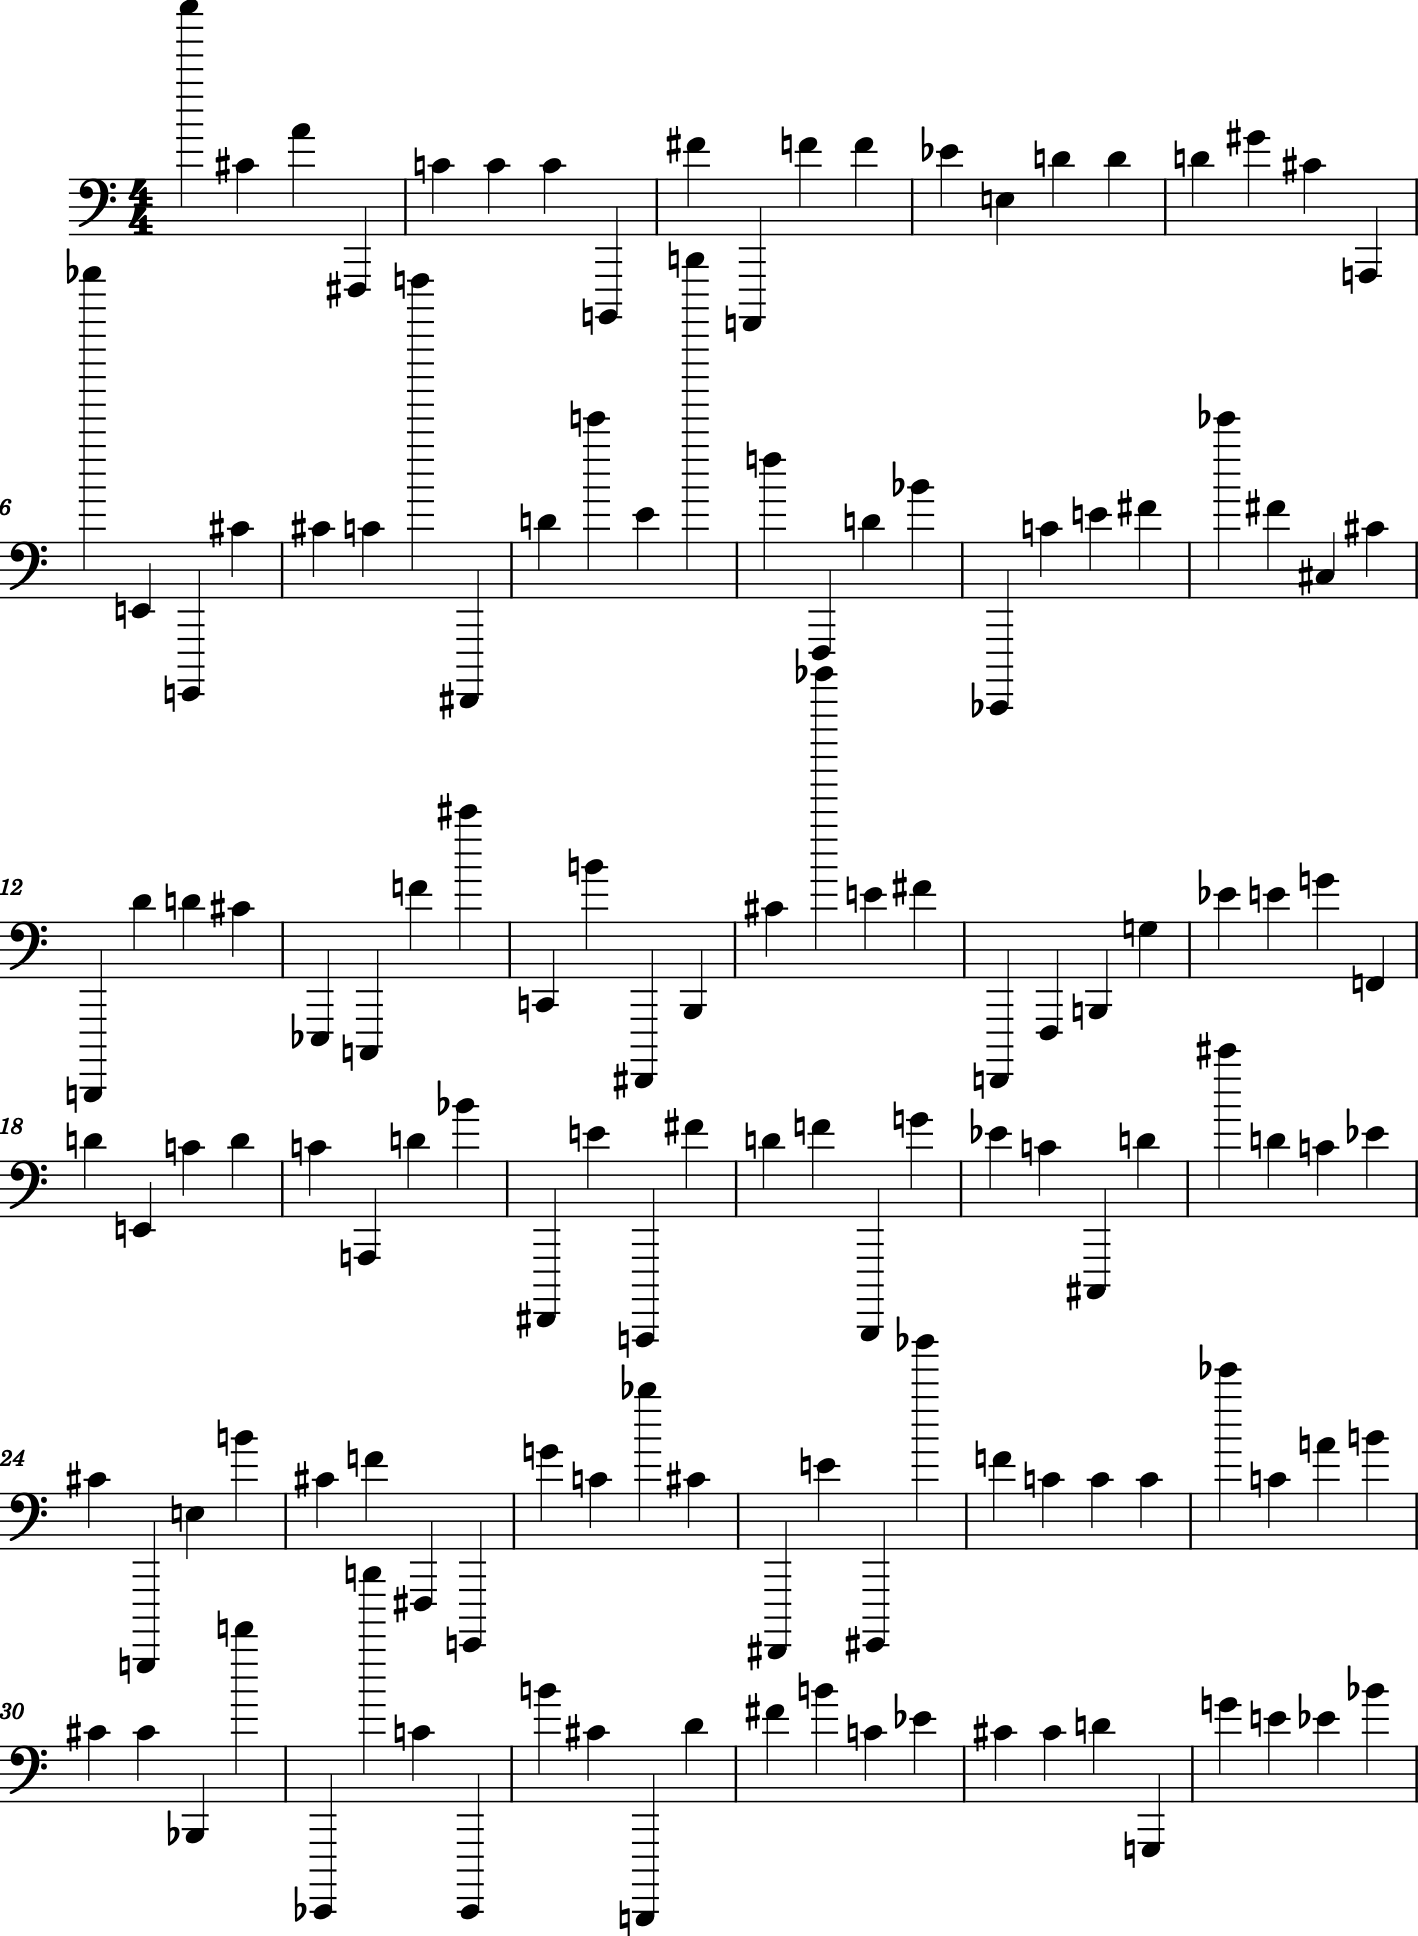

In [15]:
period_score = stream.Stream()

# Converts each note name into a note object added to the score
for n in midi_values:
    new_note = note.Note(n)
    period_score.append(new_note)

# Shows the score (opens in music notation viewer or outputs MusicXML)
period_score.show()

In [16]:
midi_values[0]

100

## Launching the Multimodal Exploration

In [17]:
def blank_image():
    return np.ones((600, 1200, 3), dtype=np.uint8)*255

def explore_lcs_with_midi(midi_file_path):
    midi_out = rtmidi.MidiOut()
    available_ports = midi_out.get_ports()
    
    if available_ports:
        midi_out.open_port(0)
        print(f"Opened MIDI port: {available_ports[0]}")
    else:
        midi_out.open_virtual_port("Virtual MIDI Output")
        print("Opened virtual MIDI output port.")
    
    mid = mido.MidiFile(midi_file_path)

    # Create a single persistent window before the loop
    window_name = 'INTEGRAL-OMC Light curves'
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, 600, 1200)

    # Start with blank image
    cv2.imshow(window_name, blank_image())
    cv2.waitKey(1)
    
    path = 'samples/'
    notes_played = 0
    counter = 0
    image_displayed = False
    
    for msg in mid.play():
        lc_found = 0
        try:
     
            if not msg.is_meta:
                midi_out.send_message(msg.bytes())
            if msg.type == 'note_on' and msg.velocity > 0:
                note = msg.note
                lc_found = 0
                for j in range(dim):
                    note2 = midi_values[j]
                    if (note == note2):
                        print("Light curve:", lc_names[j])
                        lc_found = 1                
                        name = lc_names[j][24:34]
                        img_png = path + name + '.png'
                        image = cv2.imread(img_png)
                        cv2.imshow(window_name, image)
                        image_displayed = True

                        counter += 1
                        break
    
                if lc_found == 0:
                    
                    index = int(np.random.uniform(low=0, high=len(lc_notes)))
                    lc_name = lc_names[index][24:34]
                    print("Light curve not found. Displaying a random light curve", lc_name)
                    img_png = path + lc_name + '.png'
                    image = cv2.imread(img_png)
                    cv2.imshow(window_name, image)
                    image_displayed = True               
                    counter += 1
    
    
            elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
                if image_displayed:
                    # Show blank image instead of closing window
                    cv2.imshow(window_name, blank_image())
                    image_displayed = False
    
    
    
            # Process window events, small delay (10 ms)
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
            
        except:
            print("Process error. Displaying light curve #23")
            lc_name = lc_names[23][24:34]
            img_png = path + lc_name + '.png'
            image = cv2.imread(img_png)
            cv2.imshow(window_name, image)
            image_displayed = True               
            counter += 1
        notes_played += 1 
        
    print("Notes played:", notes_played)
    print("Lightcurves found:", counter)

    # Cleanup
    cv2.destroyAllWindows()
    midi_out.close_port()

In [ ]:
if __name__ == '__main__':
    explore_lcs_with_midi(file)